## Dataset Columns

Target:
- `compressive_strength_mpa`: compressive strength in MPa.

ID:
- `batch_id`

Mix design / materials:
- `cement_kg_m3`, `water_kg_m3`, `slag_kg_m3`, `fly_ash_kg_m3`, `silica_fume_kg_m3`
- `superplasticizer_kg_m3`
- `fine_aggregate_kg_m3`, `coarse_aggregate_kg_m3`
- `air_content_pct`
- `slump_mm`

Time aged in days:
- `age_days`

Curing / environment:
- `curing_method` (water cured / air cured / sealed / steam cured)
- `temperature_C`, `humidity_pct`

Process data:
- `cement_brand` (A/B/C)
- `aggregate_type` (limestone, basalt, granite, gravel)
- `plant_id` (PLANT1 / PLANT2/ PLANT3 / PLANT4)
- `operator_shift` (day/night/swing)
- `day_of_week`

Interference:
- `nearby_traffic_count`
- `sensor_noise_index`


In [11]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

DATA_PATH = "concrete_strength.csv"

df = pd.read_csv(DATA_PATH)
df.head()

,batch_id,plant_id,operator_shift,day_of_week,cement_brand,cement_kg_m3,slag_kg_m3,fly_ash_kg_m3,silica_fume_kg_m3,water_kg_m3,...,slump_mm,mix_time_s,temperature_C,humidity_pct,curing_method,aggregate_type,nearby_traffic_count,sensor_noise_index,age_days,compressive_strength_mpa
0,838618,PLANT_04,day,6,A,253.1,0.0,59.4,0.83,212.7,...,70.0,96.0,20.7,72.0,water_cured,limestone,1180,-1.908,56,99.06
1,560573,PLANT_04,day,4,B,292.1,47.0,0.0,5.13,226.4,...,NaN,50.0,15.4,78.0,water_cured,basalt,2140,-0.979,28,87.84
2,547499,PLANT_01,day,5,B,349.0,29.2,0.0,10.37,180.9,...,169.0,79.0,20.9,62.0,air_cured,limestone,1954,-0.321,56,99.77
3,710534,PLANT_01,day,1,C,286.0,95.1,15.6,11.76,159.0,...,181.0,145.0,14.7,74.0,water_cured,limestone,4911,-1.242,28,96.24
4,647838,PLANT_03,day,2,A,310.5,96.6,70.4,7.55,169.5,...,168.0,173.0,27.5,75.0,water_cured,granite,4220,-0.244,3,93.33


In [12]:
# Inspection
print("Shape:", df.shape)
display(df.describe())

# Find missing values
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts[na_counts > 0])

Shape: (5000, 24)


,batch_id,day_of_week,cement_kg_m3,slag_kg_m3,fly_ash_kg_m3,silica_fume_kg_m3,water_kg_m3,superplasticizer_kg_m3,fine_aggregate_kg_m3,coarse_aggregate_kg_m3,air_content_pct,slump_mm,mix_time_s,temperature_C,humidity_pct,nearby_traffic_count,sensor_noise_index,age_days,compressive_strength_mpa
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.000000,5000.000000,4914.000000,5000.000000,5000.000000,4921.000000,4783.000000,5000.000000,5000.000000,4845.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,553937.361200,3.008000,330.196640,57.38482,41.61622,6.355944,174.973720,4.013838,717.616840,977.695000,2.453123,110.853230,126.750200,19.941800,64.861713,2512.626400,-0.005143,43.052600,97.376072
std,259006.781072,1.982504,69.331264,47.16277,36.87742,6.312775,24.609844,1.964223,109.065987,134.559209,1.572926,53.951767,45.376047,6.857691,17.485982,1447.259537,0.994674,60.715529,13.673727
min,100001.000000,0.000000,180.000000,0.00000,0.00000,0.000000,120.000000,0.000000,450.000000,650.000000,1.000000,10.000000,50.000000,5.000000,20.000000,3.000000,-3.742000,1.000000,34.680000
25%,331093.500000,1.000000,283.600000,14.17500,6.40000,0.000000,158.100000,2.650000,644.575000,885.575000,1.150000,66.000000,95.000000,15.200000,53.000000,1250.750000,-0.664000,14.000000,89.550000
50%,553616.500000,3.000000,328.600000,51.70000,36.35000,5.090000,174.500000,3.990000,717.800000,978.100000,1.990000,100.000000,119.000000,19.850000,65.000000,2523.500000,-0.008000,28.000000,101.190000
75%,775708.000000,5.000000,376.900000,89.90000,65.60000,10.512500,191.700000,5.350000,792.400000,1071.700000,3.200000,155.000000,152.000000,24.500000,77.000000,3740.250000,0.656000,56.000000,110.000000
max,999604.000000,6.000000,520.000000,226.00000,195.00000,34.460000,240.000000,12.000000,950.000000,1250.000000,10.000000,240.000000,420.000000,38.000000,98.000000,4999.000000,3.643000,365.000000,110.000000


slump_mm                  217
humidity_pct              155
superplasticizer_kg_m3     86
air_content_pct            79
cement_brand               63
curing_method              43
dtype: int64

In [13]:
# One Hot Encoding

from sklearn.preprocessing import OneHotEncoder

ohe_cement_brand = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
result1 = ohe_cement_brand.fit_transform(df[["cement_brand"]])
ohe_operator_shift = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
result2 = ohe_operator_shift.fit_transform(df[["operator_shift"]])
ohe_curing_method = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
result3 = ohe_curing_method.fit_transform(df[["curing_method"]])
ohe_aggregate_type = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
result4 = ohe_aggregate_type.fit_transform(df[["aggregate_type"]])

col_cement_brand = ohe_cement_brand.get_feature_names_out(["cement_brand"])
col_operator_shift = ohe_operator_shift.get_feature_names_out(["operator_shift"])
col_curing_method = ohe_curing_method.get_feature_names_out(["curing_method"])
col_aggregate_type = ohe_aggregate_type.get_feature_names_out(["aggregate_type"])

df = df.drop(columns = ["cement_brand","operator_shift","curing_method","aggregate_type"])

df = pd.concat([df, pd.DataFrame(result1, columns = col_cement_brand)], axis = 1)
df = pd.concat([df, pd.DataFrame(result2, columns = col_operator_shift)], axis = 1)
df = pd.concat([df, pd.DataFrame(result3, columns = col_curing_method)], axis = 1)
df = pd.concat([df, pd.DataFrame(result4, columns = col_aggregate_type)], axis = 1)


df.head()

,batch_id,plant_id,day_of_week,cement_kg_m3,slag_kg_m3,fly_ash_kg_m3,silica_fume_kg_m3,water_kg_m3,superplasticizer_kg_m3,fine_aggregate_kg_m3,...,operator_shift_swing,curing_method_air_cured,curing_method_sealed,curing_method_steam_cured,curing_method_water_cured,curing_method_nan,aggregate_type_basalt,aggregate_type_granite,aggregate_type_gravel,aggregate_type_limestone
0,838618,PLANT_04,6,253.1,0.0,59.4,0.83,212.7,1.75,780.6,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,560573,PLANT_04,4,292.1,47.0,0.0,5.13,226.4,0.00,771.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,547499,PLANT_01,5,349.0,29.2,0.0,10.37,180.9,7.40,835.6,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,710534,PLANT_01,1,286.0,95.1,15.6,11.76,159.0,3.63,775.3,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,647838,PLANT_03,2,310.5,96.6,70.4,7.55,169.5,7.03,707.3,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [14]:
# 1) Drop rows with any missing values (rather than imputing)

df_clean = df.dropna(axis=0).copy()

target = "compressive_strength_mpa"
to_delete = [target,"batch_id","day_of_week","nearby_traffic_count","plant_id"]
X = df_clean.drop(columns=to_delete)
y = df_clean[target]

print("After dropping NA rows:", df_clean.shape)
print("Features used:", X.shape[1])
X.head()

After dropping NA rows: (4481, 36)
Features used: 31


,cement_kg_m3,slag_kg_m3,fly_ash_kg_m3,silica_fume_kg_m3,water_kg_m3,superplasticizer_kg_m3,fine_aggregate_kg_m3,coarse_aggregate_kg_m3,air_content_pct,slump_mm,...,operator_shift_swing,curing_method_air_cured,curing_method_sealed,curing_method_steam_cured,curing_method_water_cured,curing_method_nan,aggregate_type_basalt,aggregate_type_granite,aggregate_type_gravel,aggregate_type_limestone
0,253.1,0.0,59.4,0.83,212.7,1.75,780.6,1043.1,2.24,70.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,349.0,29.2,0.0,10.37,180.9,7.40,835.6,1250.0,1.71,169.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,286.0,95.1,15.6,11.76,159.0,3.63,775.3,1007.1,8.19,181.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,310.5,96.6,70.4,7.55,169.5,7.03,707.3,997.9,2.57,168.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5,360.9,0.0,53.3,0.00,186.8,5.59,682.6,912.4,3.52,52.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# normalise data 

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

if hasattr(x_train,"columns"): #scaling train
    x_train_scaled = pd.DataFrame(x_train_scaled, columns = x_train.columns, index = x_train.index)
if hasattr(x_test,"columns"): #scaling test
    x_test_scaled = pd.DataFrame(x_test_scaled, columns = x_test.columns, index = x_test.index)

print(x_train_scaled)


      cement_kg_m3  slag_kg_m3  fly_ash_kg_m3  silica_fume_kg_m3  water_kg_m3  \
2478     -0.368224   -0.860822       1.274565          -1.015202     0.401013   
4731     -1.348645   -0.064506       0.474373          -0.966006    -0.281638   
117      -0.349369   -0.157445      -1.117818          -0.761288    -0.060901   
14       -0.848282   -0.421475      -0.904797           0.768549     0.082170   
2749     -0.194184    0.782503      -0.445984           1.709620     0.879278   
...            ...         ...            ...                ...          ...   
4933     -1.721379   -0.187017      -1.117818          -0.889832    -1.548836   
535       1.380871   -0.123649      -1.038618           1.043094    -0.130392   
3454      1.656433    1.851297      -1.117818          -0.615287     1.627333   
4197     -1.091937   -1.004454      -0.364053          -1.015202    -0.956115   
967       0.976230   -1.207229      -0.298508          -0.618461    -1.512046   

      superplasticizer_kg_m

In [20]:
# run the model

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# n_estimators is the number of trees; random_state ensures reproducibility
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(x_train_scaled, y_train)
y_pred = model.predict(x_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Random Forest Test RMSE: {rmse:.4f}")

y_mean_pred = np.full_like(y_test, y_train.mean(), dtype=float)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_mean_pred))
print(f"Baseline (predict mean) RMSE: {rmse_baseline:.4f}")

Random Forest Test RMSE: 5.2199
Baseline (predict mean) RMSE: 13.5162


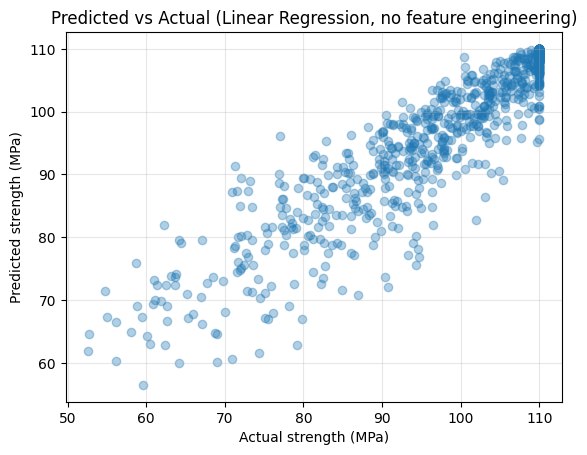

In [21]:
# Predicted vs Actual
plt.figure()
plt.scatter(y_test, y_pred, alpha=0.35)
plt.xlabel("Actual strength (MPa)")
plt.ylabel("Predicted strength (MPa)")
plt.title("Predicted vs Actual (Linear Regression, no feature engineering)")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Coefficients
coef = pd.Series(model.coef_, index=X.columns).sort_values(key=np.abs, ascending=False)
display(coef.head(15))

print("Intercept:", model.intercept_)

cement_kg_m3                 6.266862
age_days                     5.716327
water_kg_m3                 -2.250338
slag_kg_m3                   2.074648
fly_ash_kg_m3                1.491607
curing_method_air_cured     -1.218963
curing_method_water_cured    0.742868
temperature_C                0.555977
air_content_pct             -0.545435
humidity_pct                 0.489557
sensor_noise_index          -0.278747
aggregate_type_gravel       -0.259505
cement_brand_C               0.254485
aggregate_type_granite       0.227085
coarse_aggregate_kg_m3       0.184954
dtype: float64

Intercept: 97.13430245535713
